In [164]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from dynesty import NestedSampler
from dynesty import plotting as dyplot

In [419]:
import dill
import dynesty.utils
dynesty.utils.pickle_module = dill

# Write out the likelihood 
The likelihood of each of the $x,y$ points which I will write as $d$. I assume a gaussian lieklihood on the center of the points, this includes errors from measuerment and manufacturing.
The parameters which describe the circle are the centre point of the circle (may need to update this to have a parameter for the center for each segment), the radius of the circle $R$, the phase offset of the first point from the x axis $\phi$, there is also a parameter for the starting index for each segment $s$. Finally there is N which is the number of points in the circle.

The posterior on each of these parameters can be computed with bayes theorem written as
$$
p(\theta | d, N) = \frac{p(\theta | N)p(d | \theta, N)}{p(d | N)}
$$
The likelihood can be written as
$$
p(d | \theta, N) = \prod_s \prod_i \frac{1}{\sqrt{2\pi  \sigma^2}} \exp{\left( - \frac{(x_i - X_i(\theta, s))^2 - (y_i - Y_i(\theta, s))^2}{2\sigma^2}\right)},
$$
where the X and Y are the model for the x and y position in a circle.
They are defined by:
$$
X_i(\theta, s) = R\cos{\left( 2\pi (k_i + s) /N + \phi \right)} + x_c
$$
and 
$$
Y_i(\theta, s) = R\sin{\left( 2\pi (k_i + s) /N + \phi \right)} + y_c,
$$
where $k$ is an integer number of points around the circle and $s$ is the offset of the starting point for a segment.

For a suitably defined prior (Below a uniform prior on all parameters is used) one can compute the evidence $p(d | N$ using nested sampling.
This is equaivalent to the likelihood for a different form of Bayes formula,
$$
p(N | d) = \frac{p(N)p(d|N)}{p(d)}.
$$
Where assuming a flat prior on N, the likelihood is proportional to the posterior on N.
$$
p(N | d) \propto p(d | N).
$$

Below the evidence is computed for many nested sampling runs at different values of N.

In [403]:
def model(R, phase, xcent, ycent):

    xi = R*np.cos(phase) + xcent
    yi = R*np.sin(phase) + ycent

    return xi, yi



def log_likelihood(params, data, N):
    R, sigma_x, sigma_y = params[:3]
    phases, xcents, ycents = np.split(params[3:], 3)
    #x,y = data

    #k = np.arange(N)
    total_likelihood = 0
    for i, sect in enumerate(data):
        x,y = sect
        ks = np.arange(len(x))

        phase = 2*np.pi*ks/N + phases[i]
        # assume independent x,y
        xi, yi = model(R, phase, xcents[i], ycents[i])

        #xi = R*np.cos(2*np.pi*ks/N + phase) + xcent
        x_likelihood = -(xi - x)**2/(2*sigma_x**2)

        #yi = R*np.sin(2*np.pi*ks/N + phase) + ycent
        y_likelihood = -(yi - y)**2/(2*sigma_y**2)

        normlogfact = -len(x)/2. * np.log(2*np.pi*sigma_x*sigma_y)

        total_likelihood += 2*normlogfact + np.sum(x_likelihood + y_likelihood)

    return total_likelihood

In [209]:
def log_prior(params, N):
    R, phase, sigma = params[:3]
    ks = params[3:]
    angle = 2*np.pi/N 
    if 8 < N < 12 and -angle < phase < angle and 1 < R < 15 and np.all(ks) < N and 0<sigma < 1:
        return 1/params[0]
    else:
        return -np.inf

In [210]:
def log_posterior(p, data, N):
    p = np.insert(p,0,N)
    lnp = log_prior(p, N)
    if np.isfinite(lnp):
        return lnp + log_likelihood(p, data, N)
    return lnp

In [212]:
def get_data(N, R, phase, kstarts, sigma, npoints):

    data = []
    for i, kst in enumerate(kstarts):
        ks= np.arange(npoints[i]) + kst
        x,y = model(N, R, phase, ks)

        x = x + np.random.normal(0, sigma, size=len(x))
        y = y + np.random.normal(0, sigma, size=len(x))
        data.append([x,y])

    return data

# Test model

In [404]:
kstarts = np.array([1, 16, 22])
npoints = np.array([5, 2, 8])
truths = np.append(np.array([40,5,0,0.01]), kstarts)
data = get_data(truths[0], truths[1], truths[2], kstarts, truths[3], npoints)

TypeError: object of type 'numpy.float64' has no len()

KeyError: 0

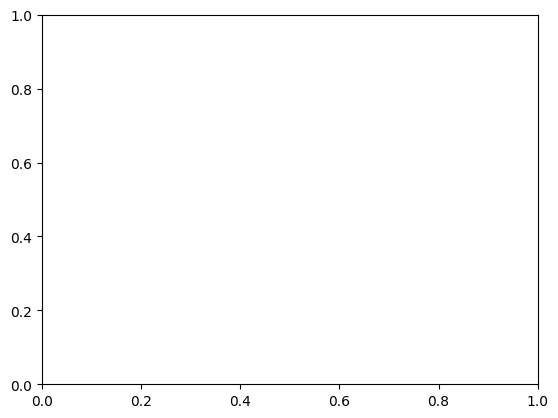

In [405]:
fig, ax = plt.subplots()
for i in range(len(data)):
    ax.plot(data[i][0], data[i][1], "o")

In [215]:

n_dim = 4 + len(kstarts)
n_walkers = 2*n_dim

Mcmc test, not sure how to get this to do what I want it to do so this isnt working yet.

In [217]:
mcpost = lambda params, data: log_posterior(params[1:], data, params[0])
sampler = emcee.EnsembleSampler(n_walkers, n_dim, mcpost, args=[data])

scales = np.array([[40., 6, 2*np.pi/15, 1]])
offsets = np.array([[5, 1, 0, 0.0]])
scales = np.append(scales, np.ones(len(kstarts)))
offsets = np.append(offsets, np.arange(len(kstarts)))
pos0 = np.random.uniform(0, 1, (n_walkers, n_dim)) * scales + offsets

sampler.run_mcmc(pos0, 5000)

State([[ 2.80658552e+01  1.19644806e+00  3.81712936e-01  7.14757953e-01
   2.85641056e-01  1.00171702e+00  2.93491523e+00]
 [ 1.55084818e+01  4.00439968e+00  2.93021869e-01  3.44583157e-01
   4.82616003e-02  1.59491231e+00  2.95923706e+00]
 [ 4.10828953e+01  5.26738363e+00  3.53747084e-01  2.83260379e-01
   7.29570474e-01  1.34946375e+00  2.49500071e+00]
 [ 8.00428191e+00 -2.78293515e-01  2.61822272e-01  9.46871142e-01
   1.20000701e+00  1.95153476e+00  1.88032155e+00]
 [ 1.14665238e+01  6.51223649e+00  1.09566379e-01  2.48516824e-01
   9.10665514e-01  1.03925893e+00  2.99747302e+00]
 [ 2.12858767e+01  3.23913467e+00  3.05899378e-02  9.60280541e-01
   2.74077156e-01  1.98177230e+00  2.83902461e+00]
 [ 1.19211461e+01  3.77784781e+00  2.10512464e-01  5.26802804e-02
   7.72323548e-01  1.99455013e+00  2.76539211e+00]
 [ 1.01863039e+01  3.46618315e+00  1.29690434e-02  4.30394742e-01
   9.00589013e-01  1.84867987e+00  2.32403242e+00]
 [ 1.29147080e+01  4.00855137e+00  2.64433232e-01  4.63113

In [218]:
# flatten all the chains
flat_samples = sampler.get_chain(discard=6000, thin=15, flat=True)
print(flat_samples.shape)

(0, 7)


In [225]:
labels = ["N", "R", "phase", "sigma"] + [f"k{i}" for i in range(len(kstarts))]

In [206]:
fg = corner.corner(flat_samples[:,:4], labels=labels[:4], truths=truths[:4])

/Users/joebayley/miniconda3/envs/general_parest/lib/python3.10/site-packages/arviz/data/base.py:220: UserWarning: More chains (1) than draws (0). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


AssertionError: I don't believe that you want more dimensions than samples!

In [ ]:
fg = corner.corner(flat_samples, labels=labels, truths=truths)

### Nested sampling test

In [226]:
plabels = labels[1:]

Prior and prior bounds

In [393]:
def prior_transform(u, bounds):
    r, phase, sigma = u[:3]
    ks = u[3:]

    outvals = []
    for i,key in enumerate(plabels):
        outvals.append(u[i]*(bounds[key][1] - bounds[key][0]) + bounds[key][0])

    return outvals


In [273]:
# Just set some uniform priors in some sensible ranges
# the phase is limited to not go past where the first point will be with the minimum number of points
test_bounds = {
    "R": (1, 10),
    "phase": (0, 2*np.pi/8),
    "sigma": (0,1)
}
for k in range(len(kstarts)):
    test_bounds[f"k{k}"] = (0,43)

In [229]:
logzs = []
samples = []
for n in range(38,43):
    dyll = lambda params: log_likelihood(params, data, n)
    dypt = lambda params: prior_transform(params, test_bounds)

    sampler = NestedSampler(dyll, dypt, ndim=3 + len(kstarts), nlive=500)

    sampler.run_nested()

    res = sampler.results

    logzs.append(res.logz[-1])

16906it [01:18, 216.65it/s, +500 | bound: 294 | nc: 1 | ncall: 267770 | eff(%):  6.513 | loglstar:   -inf < 449.127 <    inf | logz: 416.026 +/-  0.258 | dlogz:  0.001 >  0.509]
18906it [00:47, 394.81it/s, +500 | bound: 239 | nc: 1 | ncall: 210523 | eff(%):  9.240 | loglstar:   -inf < 577.577 <    inf | logz: 540.476 +/-  0.273 | dlogz:  0.001 >  0.509]
20885it [00:28, 730.98it/s, +500 | bound: 179 | nc: 1 | ncall: 155196 | eff(%): 13.824 | loglstar:   -inf < 743.142 <    inf | logz: 702.095 +/-  0.287 | dlogz:  0.001 >  0.509]
18772it [00:25, 746.42it/s, +500 | bound: 160 | nc: 1 | ncall: 139549 | eff(%): 13.860 | loglstar:   -inf < 561.924 <    inf | logz: 525.089 +/-  0.271 | dlogz:  0.001 >  0.509]
17060it [00:19, 870.69it/s, +500 | bound: 125 | nc: 1 | ncall: 113677 | eff(%): 15.516 | loglstar:   -inf < 453.756 <    inf | logz: 420.340 +/-  0.259 | dlogz:  0.001 >  0.509]


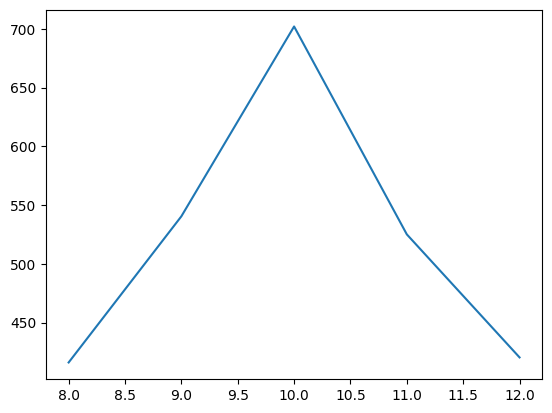

In [231]:
fig, ax = plt.subplots()
ax.plot(np.arange(8,13), logzs)

# Antikithera mechanism

Load antikethira mechanism data

In [406]:
import pandas

In [407]:
data = pandas.read_csv("./1-Fragment_C_Hole_Measurements.csv")

In [408]:
data_col = data[["Section ID", "Mean(X)", "Mean(Y)"]]

Group the data into each of the measured sections

In [409]:
data_groupeddf = data_col.groupby(data_col["Section ID"])[["Mean(X)", "Mean(Y)"]].agg(lambda x: x.tolist()).values

In [410]:
data_groupeddf

array([[list([15.59931]), list([92.59653])],
       [list([16.44167, 17.30764, 18.15278, 18.96528, 19.81389, 20.78611, 21.49722, 22.39931, 23.5125, 24.3125, 25.31736, 26.32083, 27.46389, 28.53125, 29.32083, 30.40278, 31.64028, 32.75069, 33.96945, 35.10938, 36.15139, 37.30972]),
        list([91.50069, 90.34931, 89.1625, 88.14792, 87.06875, 85.96875, 85.03403, 84.07222, 82.90486, 82.04375, 81.06458, 80.05486, 79.04167, 78.00208, 77.30833, 76.37986, 75.4493, 74.56528, 73.67847, 72.88542, 72.11111, 71.29653])],
       [list([38.50764, 39.79306, 40.87708, 42.0625, 43.15972, 44.41528, 45.525, 46.84375, 48.22569]),
        list([70.46944, 69.58333, 68.91944, 68.25972, 67.6375, 66.97569, 66.41111, 65.79792, 65.23542])],
       [list([49.62083, 50.83264, 52.18611, 53.45903, 54.60972, 55.90625, 57.11111, 58.38264, 59.72639, 61.325, 62.52292, 63.90347, 65.06389, 66.49028, 67.90694, 69.3375, 70.60417, 71.9118, 73.34722, 74.71597, 76.0007, 77.53472, 78.7625, 80.23403, 81.44375, 82.88195, 84.17639,

In [411]:
data_grouped = []
for xt, yt in data_groupeddf:
    xn = np.array(xt)
    yn = np.array(yt)
    data_grouped.append([xn, yn])


plot and estimate the center of the circle that passes through all points for prior bounds.

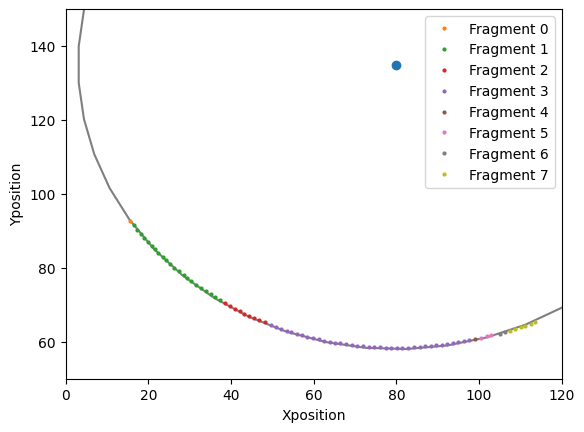

In [412]:
fig, ax = plt.subplots()
xc,yc = 80, 135
r = 77
xcirc = r*np.cos(np.linspace(0,2*np.pi)) + xc
ycirc = r*np.sin(np.linspace(0,2*np.pi)) + yc
ax.plot(xc,yc, "o")
ax.plot(xcirc,ycirc, "k",alpha=0.5)
for i,dt in enumerate(data_grouped):
    ax.plot(dt[0], dt[1], marker="o", ms=2,ls="none",label = f"Fragment {i}")

ax.set_xlabel("Xposition")
ax.set_ylabel("Yposition")
ax.set_xlim([0, 120])
ax.set_ylim([50, 150])
ax.legend(loc="upper right")

In [413]:
nsegments = len(data_grouped)

Set prior bounds

In [414]:
anti_bounds = {
    "R": (60, 100),
    "sigma_x": (0,1),
    "sigma_y": (0,1),
}
for k in range(nsegments):
    anti_bounds[f"phases{k}"] = (0,2*np.pi)
for k in range(nsegments):
    anti_bounds[f"xcent{k}"] = (70,90)
for k in range(nsegments):
    anti_bounds[f"ycent{k}"] = (130,140)

In [415]:
plabels = ["R", "sigma_x", "sigma_y"] + [f"phases{i}" for i in range(nsegments)] + [f"xcent{i}" for i in range(nsegments)] + [f"ycent{i}" for i in range(nsegments)]

In [416]:
len(anti_bounds)

27

In [420]:
anti_logzs = []
anti_samples = []
ndims = 3 + 3*nsegments
Nrange = np.array([353, 354, 355, 359, 360, 361])
print(ndims)
for n in Nrange:
    andyll = lambda params: log_likelihood(params, data_grouped, n)
    andypt = lambda params: prior_transform(params, anti_bounds)

    sampler = NestedSampler(andyll, andypt, ndim=ndims, nlive=500)

    sampler.run_nested(checkpoint_file=f'./xy_likelihood/dynesty_{n}.save')

    res = sampler.results

    anti_logzs.append(res.logz[-1])

27


64140it [22:56, 46.58it/s, +500 | bound: 347 | nc: 1 | ncall: 10215102 | eff(%):  0.633 | loglstar:   -inf < 179.636 <    inf | logz: 51.959 +/-  0.505 | dlogz:  0.001 >  0.509]    
64757it [23:53, 45.17it/s, +500 | bound: 351 | nc: 1 | ncall: 10325387 | eff(%):  0.632 | loglstar:   -inf < 181.246 <    inf | logz: 52.326 +/-  0.507 | dlogz:  0.001 >  0.509]    
64909it [24:25, 44.31it/s, +500 | bound: 353 | nc: 1 | ncall: 10338981 | eff(%):  0.633 | loglstar:   -inf < 182.218 <    inf | logz: 52.994 +/-  0.505 | dlogz:  0.001 >  0.509]    
65375it [24:32, 44.39it/s, +500 | bound: 357 | nc: 1 | ncall: 10413150 | eff(%):  0.633 | loglstar:   -inf < 184.944 <    inf | logz: 54.778 +/-  0.505 | dlogz:  0.001 >  0.509]    
65316it [42:50, 25.41it/s, +500 | bound: 351 | nc: 1 | ncall: 10397165 | eff(%):  0.633 | loglstar:   -inf < 184.032 <    inf | logz: 54.004 +/-  0.510 | dlogz:  0.001 >  0.509]    
28088it [11:10, 49.33it/s, bound: 148 | nc: 160 | ncall: 4353908 | eff(%):  0.645 | loglst

In [396]:
anti_logzs

[10232.496212184044,
 10234.566547318556,
 10234.258051569592,
 10225.776948010081,
 10218.265643827017,
 10211.207435267339]

Plot the evidence as a function if the number of points

Text(0, 0.5, 'log p(d | N)')

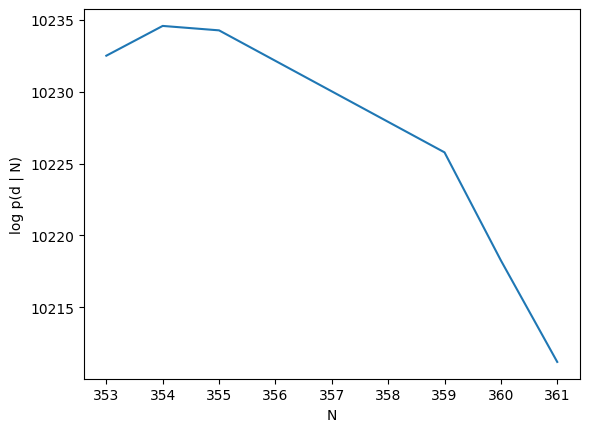

In [397]:
fig, ax = plt.subplots()
ax.plot(Nrange,anti_logzs)
ax.set_xlabel("N")
ax.set_ylabel("log p(d | N)")

Find the maximum evidence

In [398]:
maxN = Nrange[np.argmax(anti_logzs)]
print(maxN)

354


In [399]:
# bayes factor at 360 and 354 (the two plausable ones from the paper)
log_bf = anti_logzs[np.where(Nrange == 360)[0][0]] - anti_logzs[np.where(Nrange == 354)[0][0]]
print(log_bf)

-16.30090349153943


In [400]:
fandyll = lambda params: log_likelihood(params, data_grouped, maxN)
fandypt = lambda params: prior_transform(params, anti_bounds)

fsampler = NestedSampler(fandyll, fandypt, ndim=ndims, nlive=500)

fsampler.run_nested()

fres = fsampler.results

80869it [33:31, 40.20it/s, +500 | bound: 453 | nc: 1 | ncall: 13021152 | eff(%):  0.625 | loglstar:   -inf < 10395.280 <    inf | logz: 10234.190 +/-  0.569 | dlogz:  0.001 >  0.509]


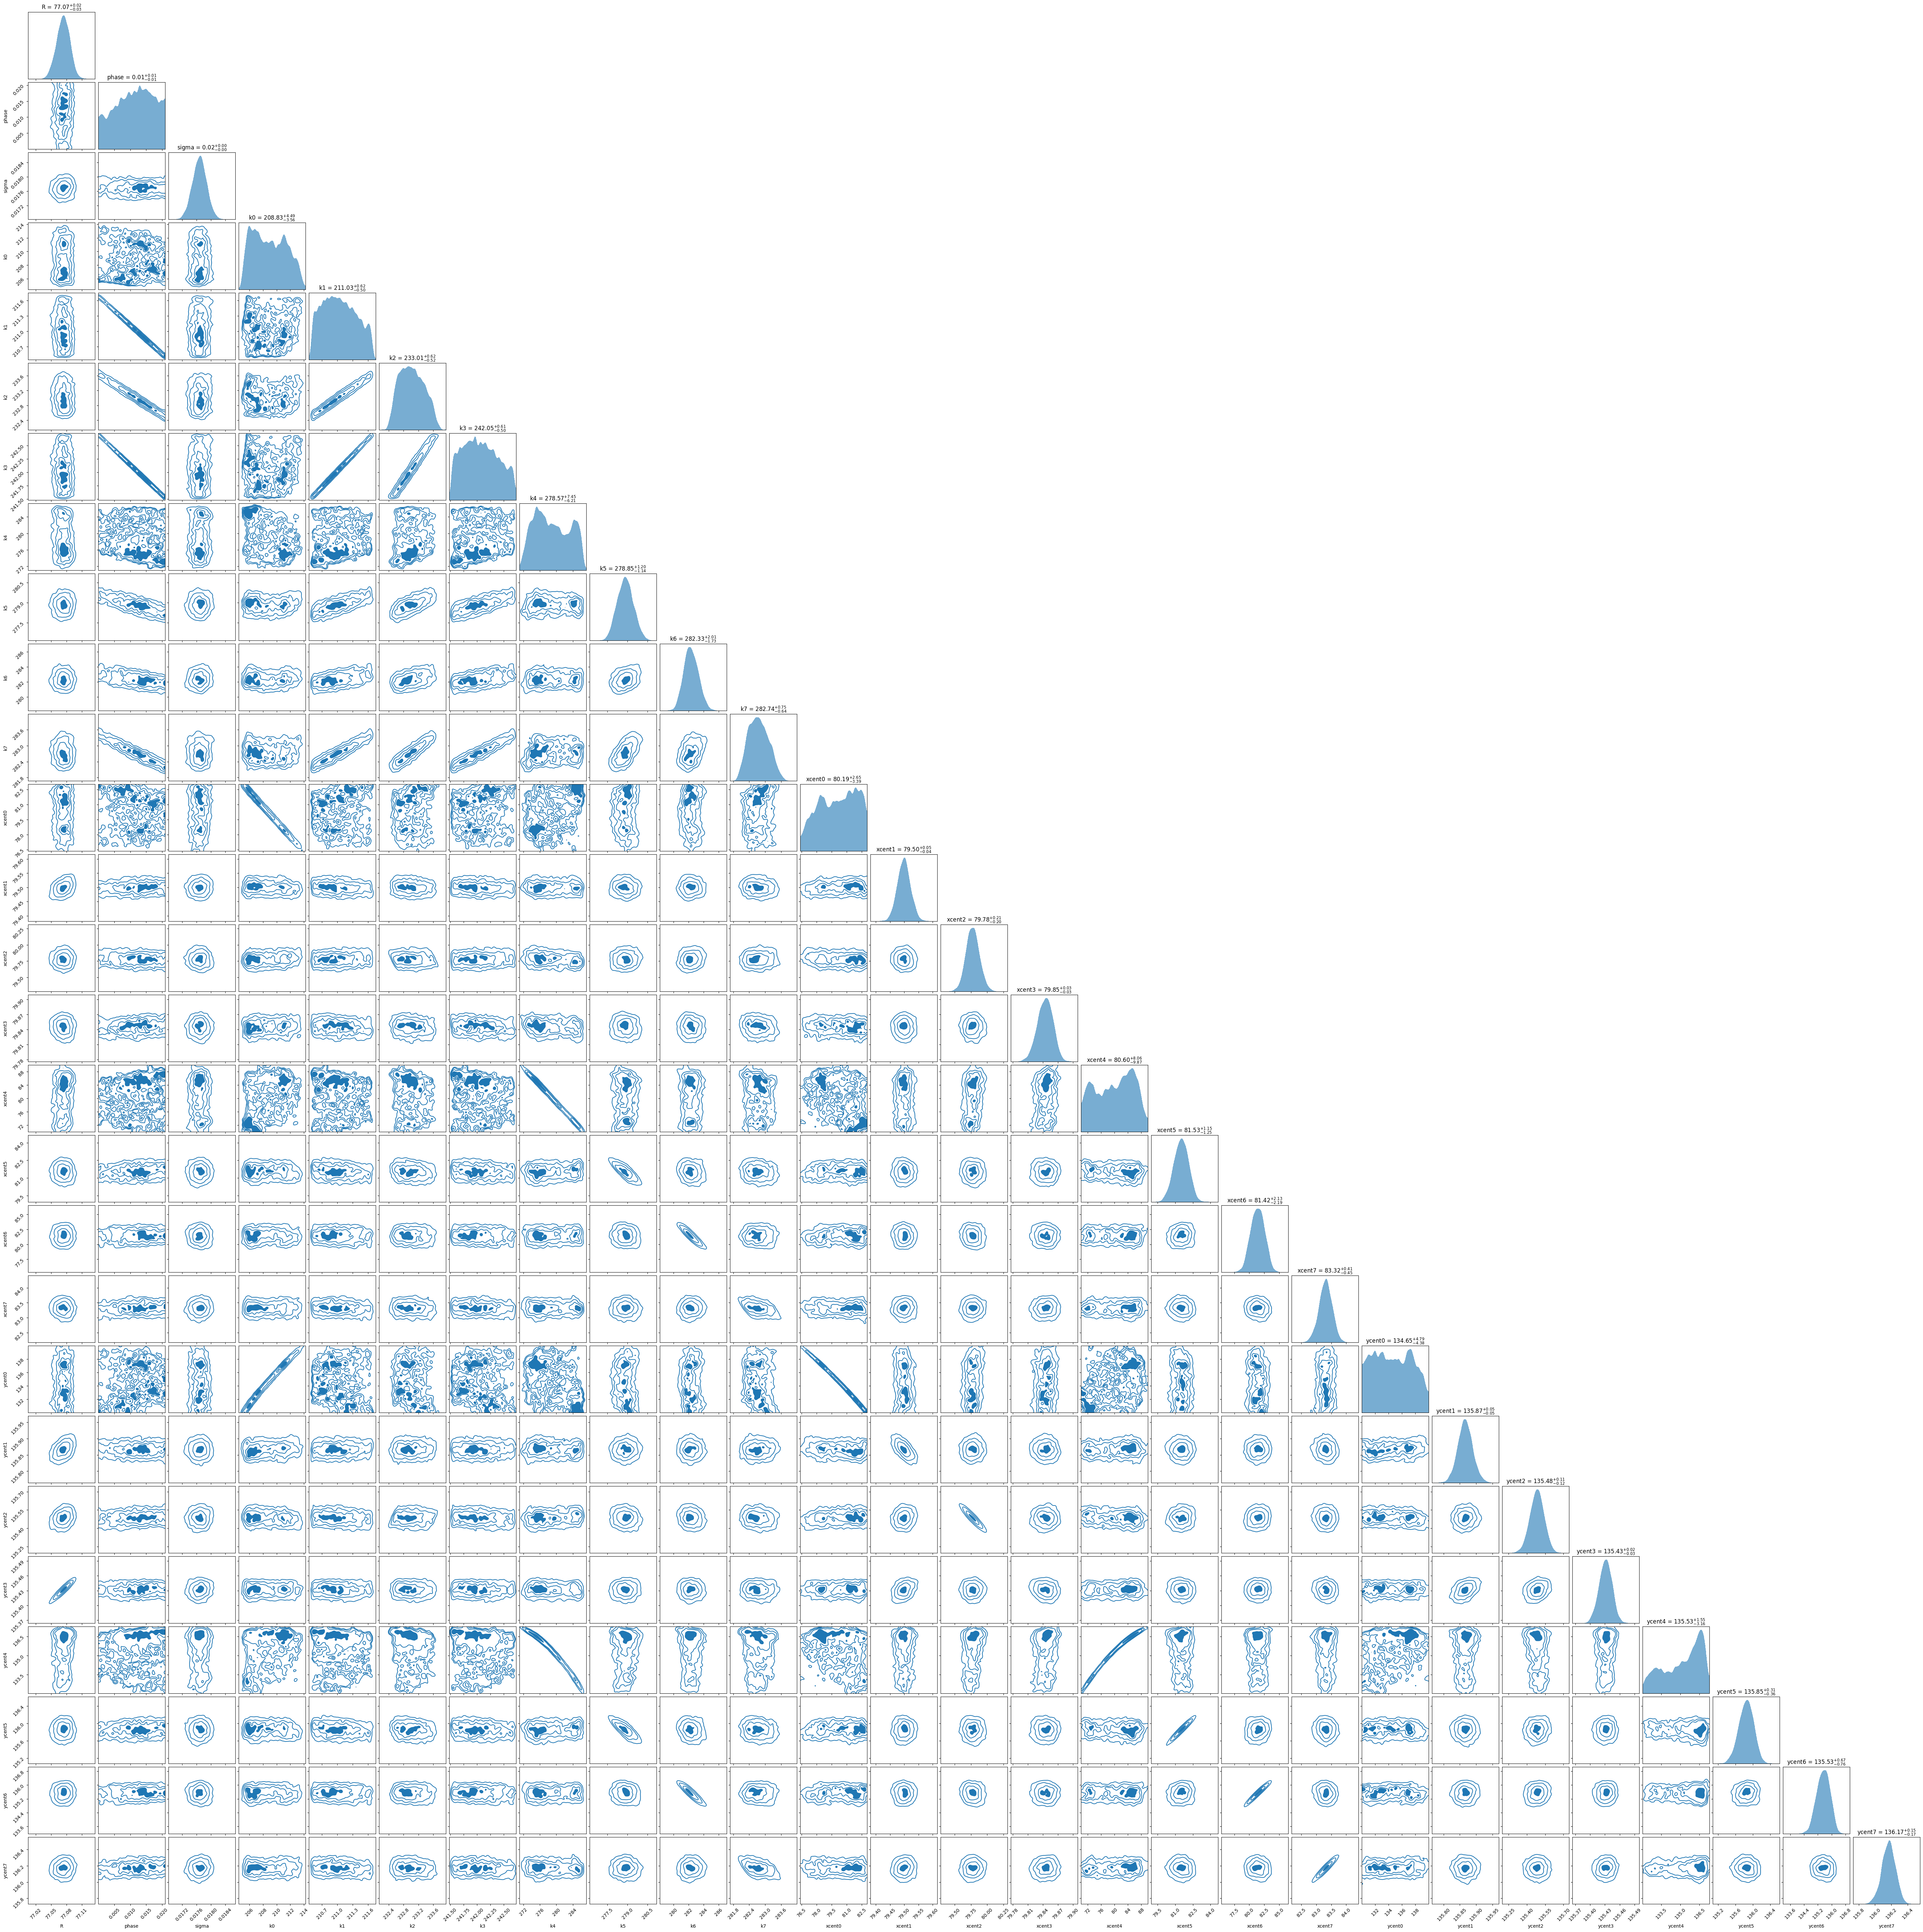

In [401]:
fg, ax = dyplot.cornerplot(fres, color='C0', labels=plabels,
                           show_titles=True, quantiles=None,)

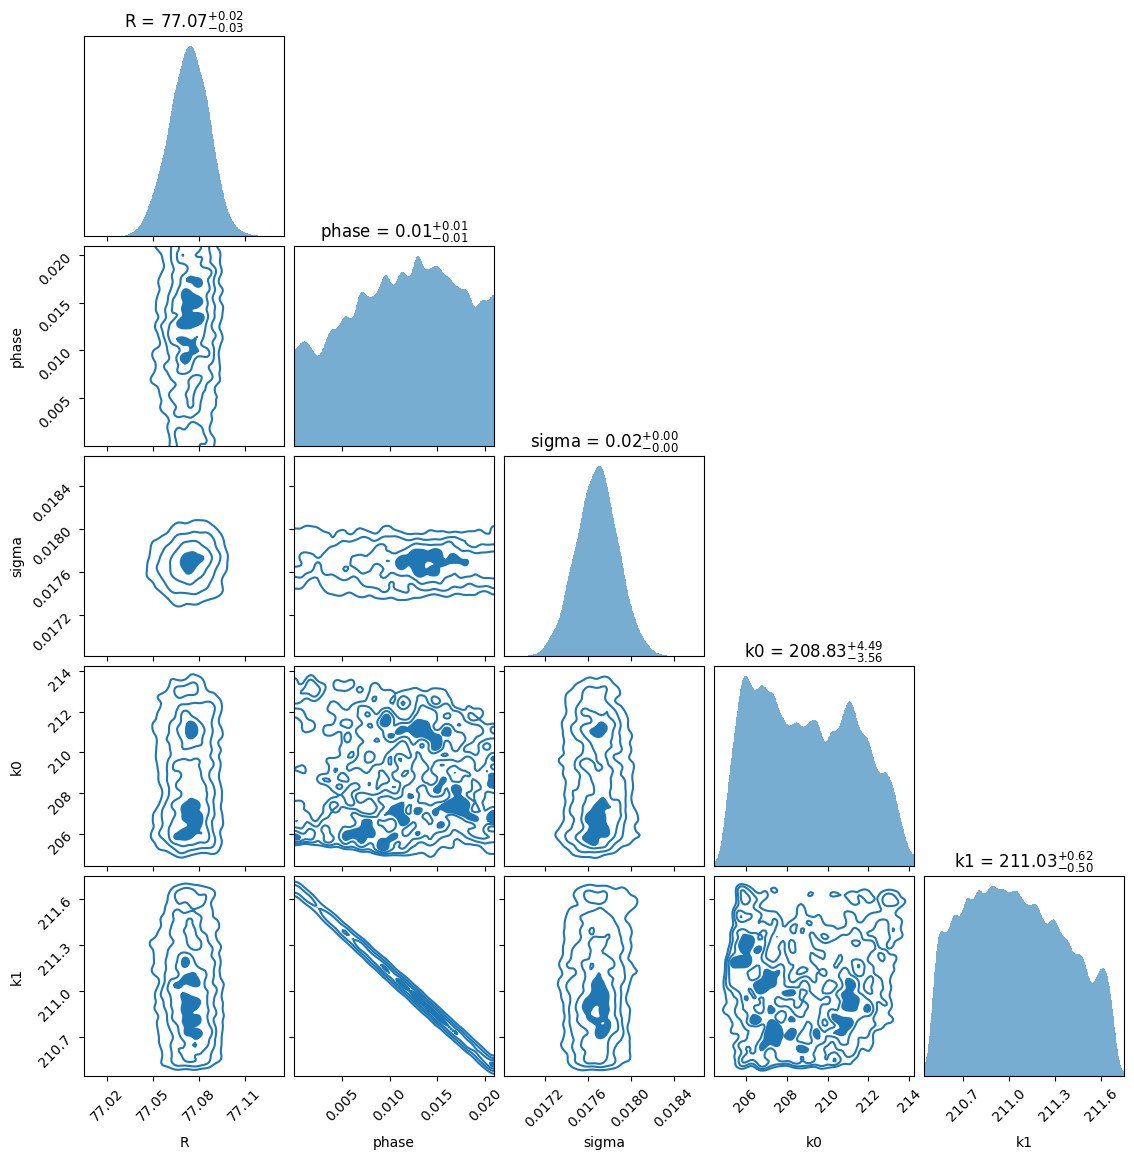

In [402]:
fg, ax = dyplot.cornerplot(fres, color='C0', labels=plabels, dims=[0,1,2,3,4],
                           show_titles=True, quantiles=None,)